# Text Classification of Masses and New Review

In [1]:
%%time

# Import necessary libraries.
import re, warnings, csv, sys, os, collections, math, itertools, scipy.stats
import pandas as pd
import numpy as np
from collections import Counter, defaultdict

# Import visualization libraries.
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns

# Import sklearn libraries for prediction/modeling.
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import label_binarize, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RepeatedStratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC

# Import NLTK collocation packages.
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

# Import stopwords.
stop_words = set(stopwords.words('english'))

# Declare directory.
abs_dir = "/Users/williamquinn/Documents/DH/Python/MJP/"

# Ignore warnings.
warnings.simplefilter("ignore")

CPU times: user 2.63 s, sys: 1.38 s, total: 4 s
Wall time: 11.6 s


## Import Data

In [2]:
%%time

# Load structured data and rename two columns.
dataframe = pd.read_csv(abs_dir + 'Output/mjp_documents.txt', sep='\t') \
    .dropna(subset=["text"], how="any") \
    .rename(columns = {"mjp_id":"mjp_index", 
                       "type":"genre"})[['mjp_index', 'magazine', 'date', 'genre', 'text']]

# Further subset to primary genres.
dataframe = dataframe[dataframe['genre'].isin(['advertisements', 'articles', 'drama',
                                               'fiction', 'letters', 'poetry'])]

# Read in New Review
newRev = pd.read_csv(abs_dir + "WebScraper/WebDirectory_Output/NewReview/newReview.txt", sep="\t")
newRev['magazine'] = "new review"
newRev['mjp_index'] = newRev.index + 10000
newRev['genre'] = "NA"

dataframe = dataframe.append(newRev, ignore_index=True)

# Convert 'date' column into recognized datetime.
dataframe['date'] = dataframe['date'].replace('(\d{4}-\d{2}).*', '\\1-01', regex=True)
dataframe['date'] = pd.to_datetime(dataframe['date'], format = '%Y-%m-%d')
dataframe['year'] = dataframe['date'].dt.year

# Subset dataframe to focus on specified magazines.
dataframe = dataframe[dataframe['magazine'].isin(['the masses', 'new review', 
                                                  'the little review', 'marsden magazines'])]

# Lower text.
dataframe['text'] = dataframe['text'].str.lower()

# Remove mastheads (and mentions) from pages.
dataframe['text'] = dataframe['text'].str \
    .replace('the masses', '') \
    .replace('new review', '') \
    .replace('poetry, a magazine of verse', '') \
    .replace('the crisis', '') \
    .replace('the little review', '') \
    .replace('marsden magazines', '') \
    .replace('the seven arts', '') \
    .replace('000', '') \
    .replace('\d+', '', regex = True) # remove any numbers.
    
# Lemmatize and stem text field.
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english", ignore_stopwords = True)

# Split documents into smaller text chunks and lemmatize/stem words.
chunk_size = 350

def splitText(string):
    words = string.split(' ')
    stemmed = [stemmer.stem(lemmatizer.lemmatize(w)) for w in words if w not in stop_words]
    grouped_words = [stemmed[i: i + chunk_size] for i in range(0, len(stemmed), chunk_size)]
    return grouped_words

dataframe['text'] = dataframe['text'].apply(splitText)

dataframe = dataframe.explode('text')

# Add word count of each chunked-text.
dataframe['wordCount'] = dataframe['text'].apply(lambda x: len(x))

# Join list of words into single string.
dataframe['text'] = dataframe['text'].apply(' '.join)

# Remove rows without text.
dataframe = dataframe.dropna(subset = ['text'])

# Remove texts with too few words (whatever chunk_size is minus 50).
dataframe = dataframe.query('wordCount >= (@chunk_size - 50)')

# Declare class (column) to predict. 
class_to_predict = "magazine"

# Set aside The Masses published in 1917 as unseen data to be predicted.
subset_1917 = dataframe.query('(year == 1917)')

# Create subset for training and testing model.
# Remove magazines that appear before New Review corpus begins and after NR ends, 1916.
dataframe = dataframe.query('(year >= 1913) & (year <= 1916) & (genre == "articles") \
    | (genre == "NA")') # | (genre == "letters)

dataframe = dataframe.reset_index()

print (dataframe.shape)
dataframe.head()

(4470, 8)
CPU times: user 1min 45s, sys: 1.27 s, total: 1min 47s
Wall time: 1min 48s


,index,mjp_index,magazine,date,genre,text,year,wordCount
0,2,4,the little review,1914-12-01,articles,great pilgrimpagan georg soul shakespear red...,1914,350
1,2,4,the little review,1914-12-01,articles,translat high serious convey littl hint warmth...,1914,350
2,2,4,the little review,1914-12-01,articles,sister brother help aris ...,1914,350
3,2,4,the little review,1914-12-01,articles,mediocr product wari insan genius mere abnorm ...,1914,350
4,2,4,the little review,1914-12-01,articles,narrow cultur like moodi found hellen ideal bl...,1914,350


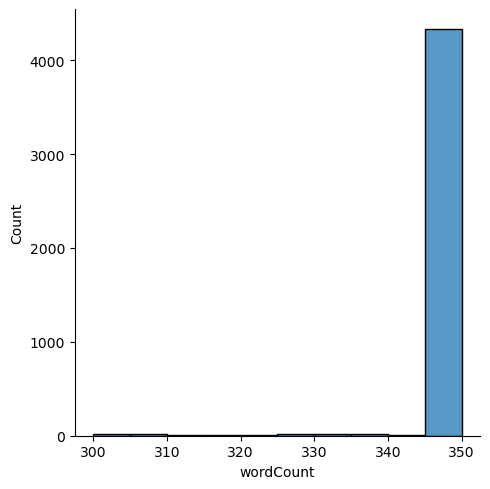

CPU times: user 393 ms, sys: 58.5 ms, total: 451 ms
Wall time: 426 ms


In [3]:
%%time

# Distribution of word counts (should be mostly 350).
sns.displot(dataframe, x = 'wordCount', bins = 10)

plt.show()

### Words Printed

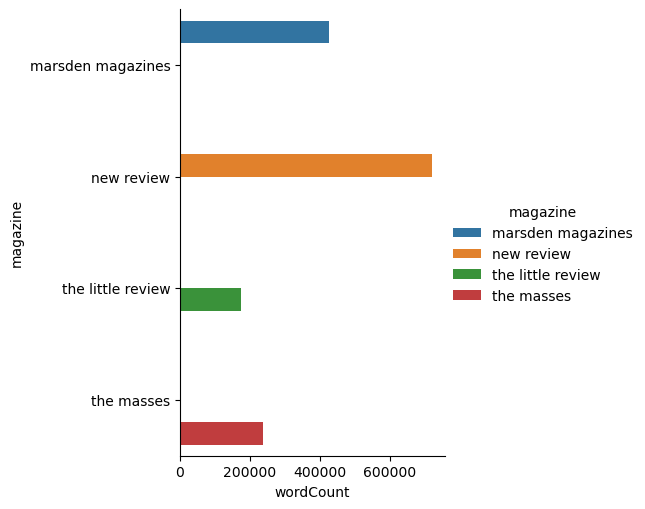

CPU times: user 499 ms, sys: 40.7 ms, total: 540 ms
Wall time: 462 ms


In [4]:
%%time

yearlyCounts = dataframe.groupby(['magazine'], as_index = False)['wordCount'].sum()

g = sns.catplot(
    data = yearlyCounts,
    kind = 'bar', x = 'wordCount', y = 'magazine', hue = 'magazine'
)

plt.show()

## Modeling Data

### Evaluation of Models

Feature shape:  (4470, 180) Label shape:  (4470,)


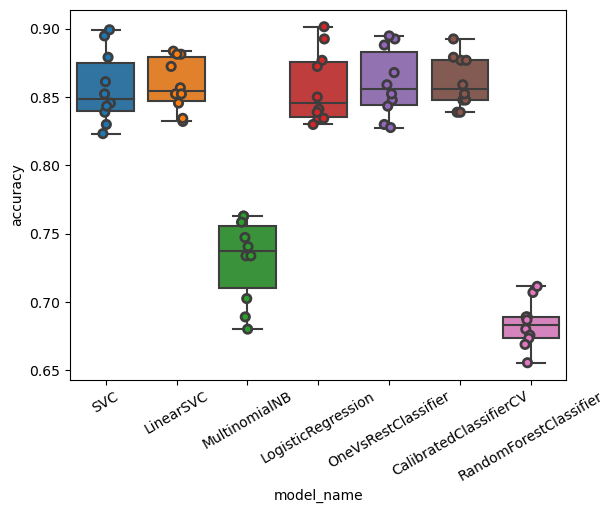

CPU times: user 4min 42s, sys: 3.91 s, total: 4min 46s
Wall time: 4min 42s


model_name
CalibratedClassifierCV    0.861074
LinearSVC                 0.859284
LogisticRegression        0.857271
MultinomialNB             0.731096
OneVsRestClassifier       0.860403
RandomForestClassifier    0.683669
SVC                       0.856823
Name: accuracy, dtype: float64

In [5]:
%%time

# Instantiate a vectorizer.
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=0.15, 
                        max_df=0.85,
                        norm='l2', 
                        encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(dataframe['text']).toarray()
labels = dataframe['magazine'].values

# Show data size.
print ('Feature shape: ', features.shape, 'Label shape: ', labels.shape)

# Declare models to evaluate.
models = [
    SVC(kernel = 'linear'),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state = 0),
    OneVsRestClassifier(SVC(kernel='linear', probability=True,
                                 random_state = 5)),
    CalibratedClassifierCV(base_estimator = LinearSVC()),
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
]

# Set up cross validation.
CV = 10

cv_df = pd.DataFrame(index=range(CV * len(models)))

# Measure accuracy of models and create dataframe of results.
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

# Visualize model accuracy.
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=6, jitter=True, edgecolor="gray", linewidth=2)

plt.xticks(rotation=30)
plt.show()

# Print accuracy report.
cv_df.groupby('model_name').accuracy.mean()

## Pipeline for Predictions

Common pitfalls and recommended practices: https://scikit-learn.org/stable/common_pitfalls.html#common-pitfalls

### Logistic Regression

#### Accuracy Measurement

* Kathuria, "[Regression—Why Mean Square Error?](https://towardsdatascience.com/https-medium-com-chayankathuria-regression-why-mean-square-error-a8cad2a1c96f)"

* Keen, "[Linear Regression in Python Using Scikit-Learn](https://benalexkeen.com/linear-regression-in-python-using-scikit-learn/)"

In [6]:
%%time

X = dataframe['text']
y = dataframe['magazine']

# Split data into training and testing sets.
# skf = StratifiedKFold(n_splits = 4)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25,
                                                    stratify = y,
                                                    random_state = 42)

# Classifier parameters determine by GridSearchSV (next cell).
# Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}
pipe = Pipeline(steps = [
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(penalty='l2', C = 0.1, 
                               class_weight = 'balanced', multi_class = 'multinomial')),
])

pipe.fit(X_train, y_train)

# Instantiate cross-validation.
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

scores = cross_val_score(pipe, X_test, y_test, cv = cv, scoring = 'accuracy')
print ("Cross Validation Accuracy: ", round(scores.mean() * 100, 2), '%')

# Repeat cross check with another method.
print ('Model Score: %.3f' % pipe.score(X_test, y_test))

# Classification report.
y_pred = pipe.predict(X_test)

print('\nClassification Report:\n', metrics.classification_report(y_test, y_pred))

Cross Validation Accuracy:  83.72 %
Model Score: 0.881

Classification Report:
                    precision    recall  f1-score   support

marsden magazines       0.92      0.85      0.89       305
       new review       0.97      0.92      0.94       515
the little review       0.63      0.87      0.73       126
       the masses       0.82      0.81      0.82       172

         accuracy                           0.88      1118
        macro avg       0.83      0.86      0.84      1118
     weighted avg       0.89      0.88      0.88      1118

CPU times: user 1min 3s, sys: 5.35 s, total: 1min 8s
Wall time: 51 s


### Grid Search for Model Tuning

Run once and then change pipeline parameters.

In [7]:
# %%time

# pipe.get_params().keys()

# param_grid = {
#     'clf__penalty': ['l1','l2'], 
#     'clf__C': [0.01,0.1,1,10,100],
#     'classifier__solver': ['newton-cg', 'sag', 'lbfgs', 'liblinear']
# }

# cv = GridSearchCV(pipe, param_grid, n_jobs = -1)
# cv.fit(X_train, y_train)

# print (f'Best Parameters: {cv.best_params_}')
# print (f'Best Score: {cv.best_score_}\n')

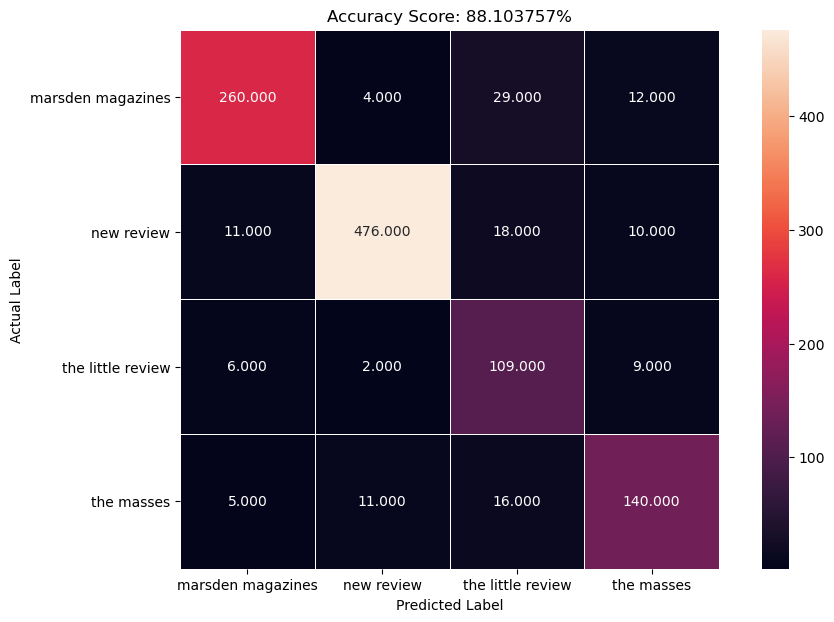

CPU times: user 886 ms, sys: 57 ms, total: 943 ms
Wall time: 830 ms


In [8]:
%%time

cm = metrics.confusion_matrix(y_test, y_pred, pipe['clf'].classes_)

fig, ax = plt.subplots(figsize=(11, 7)) 

sns.heatmap(cm, annot = True, fmt = '.3f', 
            linewidths = .5, square = True)


plt.ylabel('Actual Label')
plt.yticks(rotation = 0)

plt.xlabel('Predicted Label')
plt.title( 'Accuracy Score: {0:%}'.format(pipe.score(X_test, y_test)))

ax.set_xticklabels(pipe['clf'].classes_)
ax.set_yticklabels(pipe['clf'].classes_)

plt.show()

### Feature Coefficients

In [9]:
%%time

sign_features = pd.DataFrame()

# Set number of features to return
n_features = 12

# For each class in pipeline.
for n in range(len(pipe['clf'].coef_)):
    pred_class = pipe['clf'].classes_[n]
    
#   Gather coefficients of class [n, :], and sort in    
    important_features = pipe['clf'].coef_[n, :].argsort()[::-1]
    
    important_feat_labels = np.take(pipe['tfidf'].get_feature_names(),
                                    important_features[:n_features])
    
    features_df = pd.DataFrame({'class':pred_class, 
                                'words':important_feat_labels})
    
    features_df['rank'] = features_df.index
    
    features_df = features_df.pivot(index = 'class', columns = 'rank', values = 'words')
    
    features_df['intercept_score'] = pipe['clf'].intercept_[n]
    
    sign_features = sign_features.append(features_df)

sign_features

CPU times: user 749 ms, sys: 47.9 ms, total: 796 ms
Wall time: 827 ms


rank,0,1,2,3,4,5,6,7,8,9,10,11,intercept_score
class,,,,,,,,,,,,,
marsden magazines,egoist,le,mr,civilis,la,et,individu,term,mean,power,art,realis,0.014201
new review,th,socialist,class,war,ofth,labor,social,new,party,parti,capitalist,thi,0.365827
the little review,review,littl,life,nietzsch,love,poetri,artist,art,poet,music,soul,play,-0.190511
the masses,revolut,prison,said,church,rockefel,dont,strike,labor,armi,war,fight,day,-0.189518


### R^2 and Mean Squared Error

In [10]:
%%time

# Preprocessing.
# Binarize classes for one-vs-all fashion.
y_test_bin = label_binarize(y_test, classes = dataframe[str(class_to_predict)])
y_pred_bin = label_binarize(y_pred, classes = dataframe[str(class_to_predict)])

# R^2 Score.
print ('R^2 score: %0.3f' % metrics.r2_score(y_test_bin, y_pred_bin),
       '\nThe R^2 score indicates that amount of data explained by the model.\n')

# Mean Squared Error.
y_predict = label_binarize(pipe.predict(X_test),
                           classes = dataframe[str(class_to_predict)])

model_mse = metrics.mean_squared_error(y_predict, y_test_bin)
print ('Mean squared error: %0.3f' % math.sqrt(model_mse),
       '\nMSE compares prediction for the test data (data left out) with the ground truth for the data set.\n')

R^2 score: 0.678 
The R^2 score indicates that amount of data explained by the model.

Mean squared error: 0.237 
MSE compares prediction for the test data (data left out) with the ground truth for the data set.

CPU times: user 1.21 s, sys: 187 ms, total: 1.39 s
Wall time: 1.44 s


### Assigned Probabilities

In [11]:
%%time

probs = dataframe[['mjp_index', 'year', 'magazine', 'genre']] \
    .merge(
        pd.DataFrame(pipe.predict_proba(X_test),
                     index = X_test.index,
                     columns = pipe['clf'].classes_),
        left_index = True, right_index = True)

probs[['marsden magazines', 'new review', 'the little review', 'the masses']].describe()

CPU times: user 525 ms, sys: 24.9 ms, total: 550 ms
Wall time: 598 ms


,marsden magazines,new review,the little review,the masses
count,1118.000000,1118.000000,1118.000000,1118.000000
mean,0.246232,0.300975,0.215674,0.237119
std,0.094900,0.143337,0.090117,0.071488
min,0.072506,0.069122,0.062339,0.089595
25%,0.175128,0.178668,0.147711,0.192188
50%,0.224119,0.251935,0.196139,0.221828
75%,0.307103,0.430414,0.262684,0.261500
max,0.510336,0.677741,0.559634,0.551114


In [12]:
%%time

y_data = pd.DataFrame(y_test.copy())
y_data.columns = ['magazine']
y_data['prediction'] = y_pred

n = 0
for i, r in y_data.iterrows():
    if r['magazine'] == r['prediction']:
        n = n + 1
        
print ('Verify score: ', n / y_data.shape[0])
print (y_data['magazine'].unique())
y_data.head()

Verify score:  0.8810375670840788
['the masses' 'marsden magazines' 'new review' 'the little review']
CPU times: user 157 ms, sys: 6.16 ms, total: 163 ms
Wall time: 192 ms


,magazine,prediction
1063,the masses,the masses
397,marsden magazines,marsden magazines
4029,new review,new review
2507,new review,new review
701,the little review,the little review


## Predict Materials from 1917

In [13]:
%%time

X_sub = subset_1917['text']
y_sub = subset_1917['magazine']

# Classification report.
y_pred_sub = pipe.predict(X_sub)

print('\nClassification Report:\n', metrics.classification_report(y_sub, y_pred_sub))


Classification Report:
                    precision    recall  f1-score   support

marsden magazines       0.80      0.69      0.74       281
       new review       0.00      0.00      0.00         0
the little review       0.39      0.83      0.53       163
       the masses       0.91      0.53      0.67       536

         accuracy                           0.63       980
        macro avg       0.52      0.51      0.48       980
     weighted avg       0.79      0.63      0.67       980

CPU times: user 394 ms, sys: 12.4 ms, total: 406 ms
Wall time: 424 ms


## Visualizing Probabilities

In [19]:
%%time

predicted_probs = pd.DataFrame(pipe.predict_proba(X_sub),
                     index = X_sub.index,
                     columns = pipe['clf'].classes_) \
    .merge(
        dataframe[['mjp_index', 'year', 'magazine', 'genre']],
        left_index = True, right_index = True)


# Create new column for prediction's best guesses.
predicted_probs['best_guess'] = predicted_probs[['marsden magazines', 'the little review', 
                                                 'the masses', 'new review']] \
    .idxmax(axis = 1)

# Create new column for value of the best guess for each row.
predicted_probs['best_guess_value'] = predicted_probs \
    [['marsden magazines', 'the little review', 'the masses', 'new review']] \
    .max(axis = 1)

# Reshape dataframe (wide to long).
predicted_probs = pd.melt(predicted_probs, id_vars = ['mjp_index', 'magazine', 'year', 'genre',
                                                      'best_guess', 'best_guess_value'], 
                          value_vars = ['marsden magazines', 'the little review', 'the masses', 'new review'])

# Filter dataframe.
predicted_probs = predicted_probs.query('magazine == variable')

predicted_probs.head(4)

CPU times: user 368 ms, sys: 11 ms, total: 379 ms
Wall time: 397 ms


,mjp_index,magazine,year,genre,best_guess,best_guess_value,variable,value
59,2350,marsden magazines,1915,articles,the little review,0.311137,marsden magazines,0.266092
60,2350,marsden magazines,1915,articles,the little review,0.337702,marsden magazines,0.194370
61,2350,marsden magazines,1915,articles,the little review,0.283826,marsden magazines,0.217772
62,2350,marsden magazines,1915,articles,the little review,0.374232,marsden magazines,0.217534


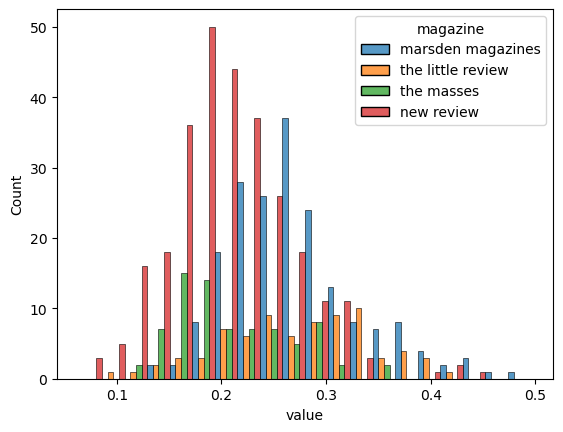

CPU times: user 463 ms, sys: 13.5 ms, total: 476 ms
Wall time: 489 ms


In [20]:
%%time

# Chart histogram of guesses.
sns.histplot(data = predicted_probs, x = 'value',
             hue = 'magazine', multiple='dodge') 

plt.show()

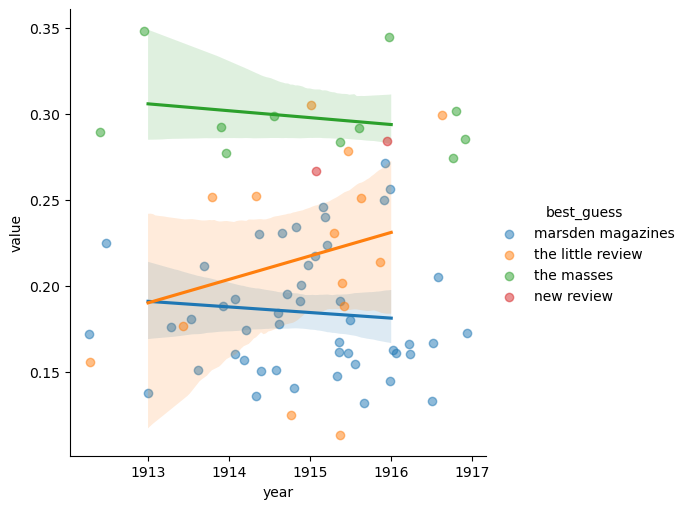

CPU times: user 1.18 s, sys: 58.8 ms, total: 1.24 s
Wall time: 1.14 s


In [26]:
%%time

# Chart guesses for The Masses.
masses = predicted_probs.query('(magazine == "the masses")')

sns.lmplot(data = masses, x = 'year', y = 'value',
           hue = 'best_guess', x_jitter = True, 
           scatter_kws = {'alpha': 0.5})

plt.show()
# masses

## Research Question(s):

* Does the model get worse at predicting The Masses after the merger, indicating an influx of New Review language?
* Is one year of data insufficient (probably), but does it point to interesting texts worth close reading?